In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import torch 
from sklearn.model_selection import train_test_split

In [2]:
coal = np.loadtxt(pm.get_data("coal.csv"))

In [3]:
# discretize data
years = int(coal.max() - coal.min())
bins = years // 4
hist, x_edges = np.histogram(coal, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist

In [4]:
with pm.Model() as model_coal:
    _μ = pmb.BART("_μ", X=x_data, Y=np.log(y_data), m=20)
    μ = pm.Deterministic("μ", pm.math.exp(_μ))
    y_pred = pm.Poisson("y_pred", mu=μ, observed=y_data)
    idata_coal = pm.sample(random_seed=10)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [_μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


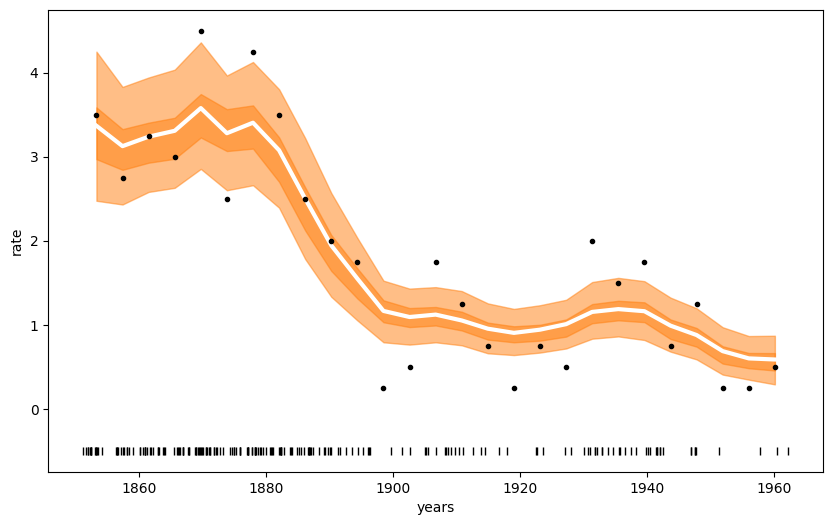

In [5]:
_, ax = plt.subplots(figsize=(10, 6))

rates = idata_coal.posterior["μ"] / 4
rate_mean = rates.mean(dim=["draw", "chain"])
ax.plot(x_centers, rate_mean, "w", lw=3)
ax.plot(x_centers, y_data / 4, "k.")
az.plot_hdi(x_centers, rates, smooth=False)
az.plot_hdi(x_centers, rates, hdi_prob=0.5, smooth=False, plot_kwargs={"alpha": 0})
ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate");

array([[<AxesSubplot:title={'center':'_μ'}>,
        <AxesSubplot:title={'center':'_μ'}>],
       [<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>]], dtype=object)

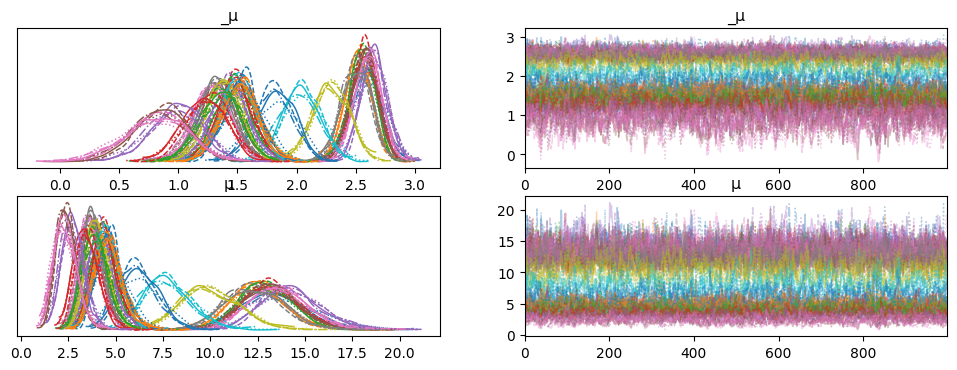

In [6]:
az.plot_trace(idata_coal)

In [30]:
n_host_sample = 80 
sigma_error = 1 
d = 10 
A = torch.randn((d,d))
A = 1/(torch.det(A)) * A

T_allocation_host = torch.randn(d)
T_allocation_host = 100/torch.norm(T_allocation_host)*T_allocation_host

mu_nc = torch.randn(d)
mu_nc = 1/torch.norm(mu_nc)*mu_nc

mu_c = torch.randn(d)
mu_c = 1/torch.norm(mu_c)*mu_c

mu = torch.concat([mu_nc,mu_c])


X_host_no_T = (torch.randn((n_host_sample,d)) @ A ) 
T_host = torch.bernoulli(torch.sigmoid(X_host_no_T@ T_allocation_host))
X_host_times_T = (T_host.unsqueeze(dim=0).T * X_host_no_T)
X_host = torch.concat([X_host_no_T,X_host_times_T],dim=1)

Y_host = X_host @ mu
Y_host = (1/Y_host.norm()) * Y_host + sigma_error * torch.randn_like(Y_host)

In [31]:
with pm.Model() as model_host:
    μ = pmb.BART("_μ", X=np.array(X_host), Y = np.array(Y_host), m=20,separate_trees=True)
    y_pred = pm.Normal("y_pred", mu=μ, observed=np.array(Y_host))
    idata_host = pm.sample(random_seed=10)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [_μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Causal Random Forests

In [32]:
from xbcausalforest import XBCF

In [33]:
NUM_TREES_PR  = 200
NUM_TREES_TRT = 100

cf = XBCF(
    #model="Normal",
    parallel=True, 
    num_sweeps=50, 
    burnin=15,
    max_depth=250,
    num_trees_pr=NUM_TREES_PR,
    num_trees_trt=NUM_TREES_TRT,
    num_cutpoints=100,
    Nmin=1,
    #mtry_pr=X1.shape[1], # default 0 seems to be 'all'
    #mtry_trt=X.shape[1], 
    tau_pr = 0.6 * np.var(Y)/NUM_TREES_PR, #0.6 * np.var(y) / /NUM_TREES_PR,
    tau_trt = 0.1 * np.var(Y)/NUM_TREES_TRT, #0.1 * np.var(y) / /NUM_TREES_TRT,
    alpha_pr= 0.95, # shrinkage (splitting probability)
    beta_pr= 2, # shrinkage (tree depth)
    alpha_trt= 0.95, # shrinkage for treatment part
    beta_trt= 2,
    p_categorical_pr = 0,
    p_categorical_trt = 0,
    standardize_target=True, # standardize y and unstandardize for prediction
         )

In [34]:
Y = np.array(Y_host,dtype=np.float32)
T = np.array(T_host,dtype=np.int32)
X = np.array(X_host_no_T,dtype=np.float32)

In [35]:
cf.fit(
    x_t=X, # Covariates treatment effect
    x=X, # Covariates outcome (including propensity score)
    y=Y,  # Outcome
    z=T, # Treatment group
)

XBCF(num_sweeps = 50, burnin = 15, max_depth = 250, Nmin = 1, num_cutpoints = 100, no_split_penality = 4.605170185988092, mtry_pr = 10, mtry_trt = 10, p_categorical_pr = 0, p_categorical_trt = 0, num_trees_pr = 200, alpha_pr = 0.95, beta_pr = 2.0, tau_pr = 0.00314712917804718, kap_pr = 16.0, s_pr = 4.0, pr_scale = False, num_trees_trt = 100, alpha_trt = 0.95, beta_trt = 2.0, tau_trt = 0.0010490430593490601, kap_trt = 16.0, s_trt = 4.0, trt_scale = False, verbose = False, parallel = True, set_random_seed = False, random_seed = 0, sample_weights_flag = True, a_scaling = True, b_scaling = True)

In [36]:
tau_xbcf = cf.predict(X, return_mean=True)

As can be seen from below, normal predict returns causal predictions and has a predictive version

In [46]:
cf.tauhats

array([[-2.51077384e-02,  3.84322879e-01,  1.48616905e-01, ...,
        -1.33663149e-02,  7.74146345e-01, -2.36413441e-01],
       [ 3.57568870e-04, -9.67561472e-02, -2.92738418e-02, ...,
        -1.30502565e-01,  5.35630881e-02, -9.98418951e-02],
       [-1.26469370e-01,  8.47115969e-02,  2.06440740e-01, ...,
         7.46931467e-02,  6.43748802e-01, -4.74707891e-02],
       ...,
       [-4.46135002e-01,  3.19940575e-01, -3.62818183e-02, ...,
         4.25116371e-02,  4.76629826e-01,  6.96040989e-02],
       [-6.88872122e-02,  8.24891401e-02,  7.01632865e-02, ...,
         5.49607903e-02,  3.14787909e-01,  3.19987748e-01],
       [-1.72107622e-01,  7.08828033e-01,  2.07826435e-01, ...,
         4.93324901e-01,  3.05367596e-01, -3.19848435e-01]])

In [44]:
cf.predict(X,return_mean=False)

array([[-2.51077384e-02,  5.27680767e-02,  1.25452459e-01, ...,
        -1.96899650e-02,  3.27302227e-01,  1.92767068e-02],
       [ 3.57568870e-04, -1.32847563e-02, -2.47110208e-02, ...,
        -1.92243782e-01,  2.26459999e-02,  8.14092013e-03],
       [-1.26469370e-01,  1.16310225e-02,  1.74263476e-01, ...,
         1.10030734e-01,  2.72171299e-01,  3.87067876e-03],
       ...,
       [-4.46135002e-01,  4.39282950e-02, -3.06266863e-02, ...,
         6.26240405e-02,  2.01514875e-01, -5.67538717e-03],
       [-6.88872122e-02,  1.13258760e-02,  5.92271573e-02, ...,
         8.09629313e-02,  1.33089544e-01, -2.60911984e-02],
       [-1.72107622e-01,  9.73230949e-02,  1.75433187e-01, ...,
         7.26718627e-01,  1.29106719e-01,  2.60798391e-02]])

In [48]:
cf.predict(X,return_mean=False)

array([[-2.51077384e-02,  5.27680767e-02,  1.25452459e-01, ...,
        -1.96899650e-02,  3.27302227e-01,  1.92767068e-02],
       [ 3.57568870e-04, -1.32847563e-02, -2.47110208e-02, ...,
        -1.92243782e-01,  2.26459999e-02,  8.14092013e-03],
       [-1.26469370e-01,  1.16310225e-02,  1.74263476e-01, ...,
         1.10030734e-01,  2.72171299e-01,  3.87067876e-03],
       ...,
       [-4.46135002e-01,  4.39282950e-02, -3.06266863e-02, ...,
         6.26240405e-02,  2.01514875e-01, -5.67538717e-03],
       [-6.88872122e-02,  1.13258760e-02,  5.92271573e-02, ...,
         8.09629313e-02,  1.33089544e-01, -2.60911984e-02],
       [-1.72107622e-01,  9.73230949e-02,  1.75433187e-01, ...,
         7.26718627e-01,  1.29106719e-01,  2.60798391e-02]])

In [50]:
cf.predict(X,X1=X,return_mean=False,return_muhat=True)

(array([[-2.51077384e-02,  5.27680767e-02,  1.25452459e-01, ...,
         -1.96899650e-02,  3.27302227e-01,  1.92767068e-02],
        [ 3.57568870e-04, -1.32847563e-02, -2.47110208e-02, ...,
         -1.92243782e-01,  2.26459999e-02,  8.14092013e-03],
        [-1.26469370e-01,  1.16310225e-02,  1.74263476e-01, ...,
          1.10030734e-01,  2.72171299e-01,  3.87067876e-03],
        ...,
        [-4.46135002e-01,  4.39282950e-02, -3.06266863e-02, ...,
          6.26240405e-02,  2.01514875e-01, -5.67538717e-03],
        [-6.88872122e-02,  1.13258760e-02,  5.92271573e-02, ...,
          8.09629313e-02,  1.33089544e-01, -2.60911984e-02],
        [-1.72107622e-01,  9.73230949e-02,  1.75433187e-01, ...,
          7.26718627e-01,  1.29106719e-01,  2.60798391e-02]]),
 array([[ 0.36384703,  0.19909126, -0.13392373, ...,  0.05747686,
         -0.41606857, -0.06166935],
        [-0.43824796,  0.15660824, -0.48034944, ...,  0.09532401,
         -0.29985119, -0.04922646],
        [-0.77919189,  0.